In [1]:
"""
Source: https://pypi.org/project/numpyro/ 

We demonstrate how to use NUTS to do inference on a simple (small)
Bayesian neural network with two hidden layers.
"""

import argparse

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import jax.numpy as np
import jax.random as random
from jax import vmap
from jax.config import config as jax_config

import numpyro.distributions as dist
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc


In [2]:
matplotlib.use('Agg')  # noqa: E402

In [3]:
# the non-linearity we use in our neural network
def nonlin(x):
    return np.tanh(x)

In [4]:
# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, Y, D_H):
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    z1 = nonlin(np.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = sample("w2", dist.Normal(np.zeros((D_H, D_H)), np.ones((D_H, D_H))))  # D_H D_H
    z2 = nonlin(np.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = sample("w3", dist.Normal(np.zeros((D_H, D_Y)), np.ones((D_H, D_Y))))  # D_H D_Y
    z3 = np.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    sample("Y", dist.Normal(z3, sigma_obs), obs=Y)

In [5]:
# helper function for HMC inference
def run_inference(model, args, rng, X, Y, D_H):
    init_params, potential_fn, constrain_fn = initialize_model(rng, model, X, Y, D_H)
    samples = mcmc(args.num_warmup, args.num_samples, init_params,
                   sampler='hmc', potential_fn=potential_fn, constrain_fn=constrain_fn)
    return samples

In [6]:
# helper function for prediction
def predict(model, rng, samples, X, D_H):
    model = substitute(seed(model, rng), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']

In [7]:
# create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    onp.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, onp.newaxis], np.arange(D_X))
    W = 0.5 * onp.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * onp.random.randn(N)
    Y = Y[:, onp.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, onp.newaxis], np.arange(D_X))

    return X, Y, X_test

In [22]:
def main(args):
    jax_config.update('jax_platform_name', args.device)
    N, D_X, D_H = args.num_data, 3, args.num_hidden
    X, Y, X_test = get_data(N=N, D_X=D_X)

    # do inference
    rng, rng_predict = random.split(random.PRNGKey(0))
    samples = run_inference(model, args, rng, X, Y, D_H)

    # predict Y_test at inputs X_test
    vmap_args = (samples, random.split(rng_predict, args.num_samples))
    predictions = vmap(lambda samples, rng: predict(model, rng, samples, X_test, D_H))(*vmap_args)
    predictions = predictions[..., 0]

    # compute mean prediction and confidence interval around median
    mean_prediction = np.mean(predictions, axis=0)
    percentiles = onp.percentile(predictions, [5.0, 95.0], axis=0)

    # make plots
    fig, ax = plt.subplots(1, 1)

    # plot training data
    ax.plot(X[:, 1], Y[:, 0], 'kx')
    # plot 90% confidence level of predictions
    ax.fill_between(X_test[:, 1], percentiles[0, :], percentiles[1, :], color='lightblue')
    # plot mean prediction
    ax.plot(X_test[:, 1], mean_prediction, 'blue', ls='solid', lw=2.0)
    ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

    plt.savefig('bnn_plot.pdf')
    plt.savefig('bnn_plot.png')
    plt.close()

In [23]:
parser = argparse.ArgumentParser(description="Bayesian neural network example")
parser.add_argument("-n", "--num-samples", nargs="?", default=2000, type=int)
parser.add_argument("--num-warmup", nargs='?', default=1000, type=int)
parser.add_argument("--num-data", nargs='?', default=100, type=int)
parser.add_argument("--num-hidden", nargs='?', default=5, type=int)
parser.add_argument("--device", default='cpu', type=str, help='use "cpu" or "gpu".')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
args = parser.parse_args()


main(args)


sample: 100%|██████████| 2000/2000 [01:29<00:00, 22.41it/s, 1023 steps of size 3.40e-03. acc. prob=0.89]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
            prec_obs      18.26       2.74      13.89      22.52    2031.29       1.00
             w1[0,0]      -0.07       1.14      -1.85       1.78     189.61       1.00
             w1[0,1]       0.12       1.24      -1.90       1.99     232.99       1.01
             w1[0,2]      -0.14       1.13      -2.03       1.65     242.62       1.00
             w1[0,3]       0.03       1.16      -1.69       2.00     143.76       1.01
             w1[0,4]      -0.04       1.05      -1.78       1.65     184.47       1.01
             w1[1,0]       0.01       1.15      -1.89       1.65     234.22       1.00
             w1[1,1]      -0.16       1.12      -1.79       1.65     270.98       1.00
             w1[1,2]       0.19       1.14      -1.66       1.77     157.92       1.00
             w1[1,3]       0.03       1.17      -1.72       1.77     161.02       1.03
             w1[1,4]       0.02       1.1

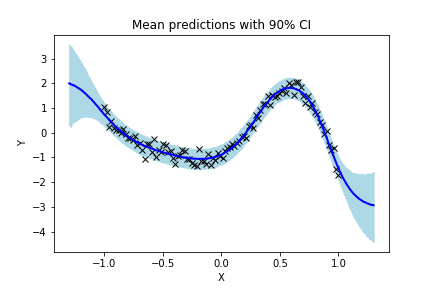

In [27]:
from IPython.display import Image
Image('bnn_plot.png')